In [1]:
'''
#! mkdir SPADE-unet-gan
#! mkdir SPADE-unet-gan/src
#! mkdir SPADE-unet-gan/src/model
! git clone https://github.com/AndreyYashkin/SPADE-gan.git
! pip install -Uqq fastai

from google.colab import drive
drive.mount('/content/drive/')
! cp /content/drive/MyDrive/archive.zip  archive.zip

! mkdir SPADE-unet-gan/data
! rm -rf 'SPADE-unet-gan/data/ADE20K Outdoors'
! unzip archive.zip -d 'SPADE-unet-gan/data/ADE20K Outdoors'
'''

"\n! mkdir SPADE-unet-gan\n! mkdir SPADE-unet-gan/src\n! mkdir SPADE-unet-gan/src/model\n! pip install -Uqq fastai\n\nfrom google.colab import drive\ndrive.mount('/content/drive/')\n! cp /content/drive/MyDrive/archive.zip  archive.zip\n\n! mkdir SPADE-unet-gan/data\n! rm -rf 'SPADE-unet-gan/data/ADE20K Outdoors'\n! unzip archive.zip -d 'SPADE-unet-gan/data/ADE20K Outdoors'\n"

In [ ]:
! nvidia-smi # Tesla P100-PCIE, Tesla T4  

In [ ]:
%cd SPADE-gan

In [4]:
import os
from fastai.vision.all import *

from src.callblocks import *
from src.cgan import *
from src.data import *
from src.show import *

from src.model.discriminator import *
from src.model.perceptual_loss import *
from src.model.gan_loss import * #gen_hinge_loss, dis_hinge_loss
from src.model.generator import Generator, GenerationSize

In [5]:
def img_to_mask_path(path):
  path = str(path).replace('ADE20K Outdoors/images', 'ADE20K Outdoors/annotations')
  path = path[:-4] + '.png'
  return Path(path)

In [6]:
bs = 30 #32 #30
im_size = GenerationSize.s_128x128
nz = 256
gen_norm = nn.InstanceNorm2d
dis_norm = nn.InstanceNorm2d
#epoches = 100 #20#0
lr = 2e-4

class_n = 150 + 1 # +1 is an unknown class
ngf = 64
embedding_dim = 128
ndf = 64
dis_layers = 4

save_to = '/content/drive/MyDrive/SPADE/3'

In [7]:
TensorMask._show_args['cmap'] = 'hsv'

In [8]:
path = 'data/ADE20K Outdoors/images'
batch_tfms = [ToOneHotTransform(class_n), Normalize.from_stats(*gan_stats)]
dls = SpadeDataLoaders.from_mask_path_func(path, img_to_mask_path, nz, bs=bs, item_tfms=Resize(im_size), batch_tfms=batch_tfms, seed=42)

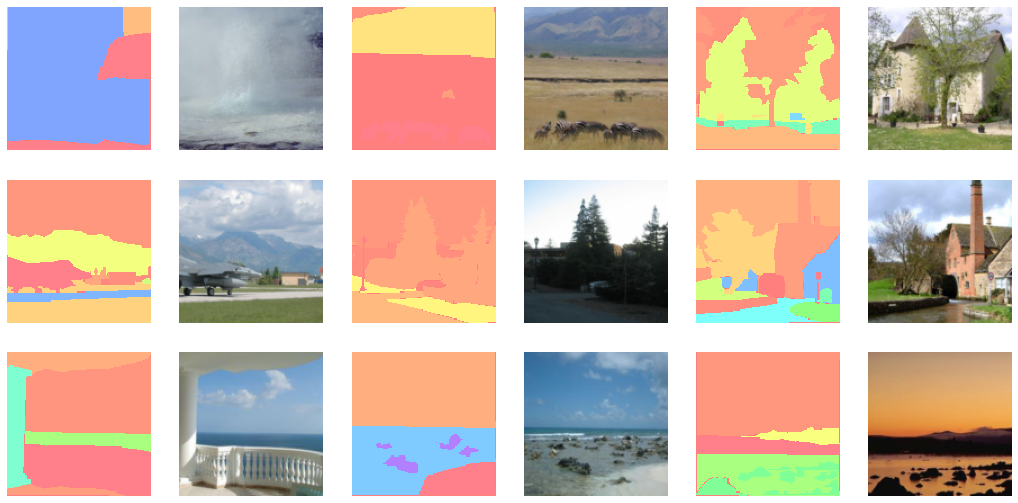

In [9]:
dls.show_batch(max_n=9)

In [10]:
max_n = 24
test_batch = list(dls.one_batch())
for i in range(len(test_batch)):
  test_batch[i] = test_batch[i][:max_n]

In [11]:
#for i in range(test_batch[1].shape[0]):
#  torch.argmax(test_batch[1][i], dim=0).show()

In [12]:
record = 'record8'
cbs = GANEvolutionRecorder(storege_path=os.path.join(save_to, record), test_batch=test_batch, plot_fn=plot_record_fn)

In [13]:
gen = Generator(im_size, nz, ngf, class_n, embedding_dim=embedding_dim, norm_type=gen_norm)
#dis = Discriminator(ndf, dis_layers, class_n)
dis_arch = partial(Discriminator, ndf, dis_layers, class_n, norm_type=dis_norm)
dis = MultiScaleDiscriminator(dis_arch, 2)
switcher = FixedGANSwitcher(n_crit=1, n_gen=1)

opt_func = partial(Adam, mom=0.5, sqr_mom=0.999)
perceptual_loss = PerceptualLoss.from_VGG19().cuda()
gen_loss = GenLoss(gen_hinge_loss, perceptual_loss, 10)
learn = GANLearner_modified(dls, gen, dis, gen_loss, dis_hinge_loss, lr=lr, prepare_crit_batch_func=add_mask, switcher=switcher, cbs=cbs, opt_func=opt_func)

learn.recorder.train_metrics=True
learn.recorder.valid_metrics=False

In [14]:
dis

MultiScaleDiscriminator(
  (dis_l): ModuleList(
    (0): Discriminator(
      (body): Sequential(
        (0): Conv2d(154, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
        (1): LeakyReLU(negative_slope=0.2)
        (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
        (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (4): LeakyReLU(negative_slope=0.2, inplace=True)
        (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
        (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (7): LeakyReLU(negative_slope=0.2, inplace=True)
        (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
        (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (10): LeakyReLU(negative_slope=0.2, inplace=True)
        (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padd

In [15]:
#gen

In [ ]:
learn.fit(100, lr)

In [ ]:
#learn.save(os.path.join(save_to, '100 epoch'), with_opt=True)

In [ ]:
learn.show_results(max_n=9, ds_idx=0)

In [ ]:
#learn.load(os.path.join(save_to, '100 epoch'))

In [ ]:
learn.fit(100, lr)

In [ ]:
#learn.save(os.path.join(save_to, '200 epoch'), with_opt=True)

In [ ]:
learn.show_results(max_n=9, ds_idx=0)

In [ ]:
#learn.load(os.path.join(save_to, '200 epoch'))

In [ ]:
#sched = {'lr': SchedExp(start=lr, end=lr/20)} for 200 epoch
sched = {'lr': SchedExpPart(start=lr, end=lr/20, start_part=0.0, end_part=0.5)}
learn.fit(100, cbs=ParamScheduler(sched))

In [ ]:
#learn.save(os.path.join(save_to, '300 epoch'), with_opt=True)

In [ ]:
learn.show_results(max_n=9, ds_idx=0)

In [ ]:
#learn.load(os.path.join(save_to, '300 epoch'))

In [ ]:
sched = {'lr': SchedExpPart(start=lr, end=lr/20, start_part=0.5, end_part=1.0)}
learn.fit(100, cbs=ParamScheduler(sched))